In [1]:
# Real life data

import logging
import threading
import json
import itertools
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import ibm_db
import shap

from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d
import seaborn as seabornInstance

from sqlalchemy import Column, Integer, String, Float, DateTime, Boolean, func
from iotfunctions import base
from iotfunctions import bif
from iotfunctions.db import Database
from iotfunctions import entity
from iotfunctions import metadata
from iotfunctions.metadata import EntityType
from iotfunctions.enginelog import EngineLogging
from iotfunctions.dbtables import FileModelStore
from iotfunctions import estimator
from iotfunctions.ui import (UISingle, UIMultiItem, UIFunctionOutSingle,
                 UISingleItem, UIFunctionOutMulti, UIMulti, UIExpression,
                 UIText, UIStatusFlag, UIParameters)
from iotfunctions.dbtables import FileModelStore, DBModelStore
from mmfunctions.anomaly import (SaliencybasedGeneralizedAnomalyScore, SpectralAnomalyScore,
                 FFTbasedGeneralizedAnomalyScore, KMeansAnomalyScore, SimpleRegressor)
from mmfunctions.bif import CumulativeCount
from iotfunctions.anomaly import GBMRegressor
import datetime as dt
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.covariance import MinCovDet
from sklearn import metrics
import scipy as sp
import scipy.fftpack
#import skimage as ski  
#from skimage import util as skiutil # for nifty windowing
import pyod as pyod
from pyod.utils.data import generate_data
from pyod.utils.data import evaluate_print
from pyod.utils.example import visualize
from pyod.models.knn import KNN
from pyod.models.iforest import IForest
%matplotlib inline
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

EngineLogging.configure_console_logging(logging.INFO)

In [2]:
# dummy db handler
db_schema=None
class DatabaseDummy:
    tenant_id = '###_IBM_###'
    db_type = 'db2'
    model_store = FileModelStore('./')
    def _init(self):
        return

db = DatabaseDummy()
        
print (db.tenant_id)

2023-01-12T13:46:27.781 INFO iotfunctions.dbtables.__init__ Init FileModelStore with path: ./
###_IBM_###


In [4]:
# Just some test data as starting point
df_input_raw = pd.read_csv('./data/MFPrinter1_LI.csv', parse_dates=['timestamp'])

In [5]:
# turn it into pipeline digestible format
df_input = df_input_raw.set_index(['id', 'timestamp'])


In [8]:
# create some test data for RANSAC
df = df_input
df['IR'] = np.random.normal(loc=100, scale=1.1, size=len(df['paperSheetsPrintedSafe']))
df['IB'] = df['IR'] + np.random.normal(loc=0, scale=1.1, size=len(df['paperSheetsPrintedSafe'])) * 5
df['IY'] = df['IR'] + np.random.normal(loc=0, scale=1.1, size=len(df['paperSheetsPrintedSafe'])) * 5

In [9]:
from mmfunctions.anomaly import RANSACRegressor

# set up mini Monitor pipeline
EngineLogging.configure_console_logging(logging.DEBUG)

jobsettings = { 'db': db, 
               '_db_schema': 'public', 'save_trace_to_file' : True}

# pass D04_VALUE as input parameter, window size of 5, output parameter will be 
#    GunPressure_KMeans
#
test3 = RANSACRegressor(['IR','IB'],targets=['IY'],outliers='outliers')

et3 = test3._build_entity_type(columns = [Column('GunPressure_Kmeans',Float())], **jobsettings)
et3._timestamp = 'timestamp'
test3._entity_type = et3
test3.auto_train = True
test3.delete_existing_models = True
#dfs[0] = test.execute(df=dfs[0])

EngineLogging.configure_console_logging(logging.INFO)

2023-01-12T13:49:57.760 DEBUG iotfunctions.enginelog.configure_console_logging Console logging has been configured. Level = 10
2023-01-12T13:49:57.763 DEBUG iotfunctions.metadata.__init__ Initializing new entity type using iotfunctions 8.8.0
2023-01-12T13:49:57.764 DEBUG iotfunctions.util.__init__ Starting trace
2023-01-12T13:49:57.765 DEBUG iotfunctions.util.__init__ Trace name: auto_trace_test_entity_for_RANSACRegressor_20230112124957
2023-01-12T13:49:57.767 DEBUG iotfunctions.util.__init__ auto_save None
2023-01-12T13:49:57.768 DEBUG iotfunctions.util.categorize_args categorizing arguments
2023-01-12T13:49:57.769 INFO iotfunctions.metadata.__init__ The entity type is not connected to a metric input table.
2023-01-12T13:49:57.770 DEBUG iotfunctions.metadata.__init__ Initialized entity type 
LocalEntityType:TEST_ENTITY_FOR_RANSACREGRESSOR
Functions:
Granularities:
No schedules metadata


In [10]:
# apply RANSAC
df_input = test3.execute(df=df_input)

2023-01-12T13:50:28.905 ERROR iotfunctions.base.get_bucket_name Could not find credentials for entity type. COS read/write is disabled 
2023-01-12T13:50:28.905 INFO iotfunctions.base.delete_models Model names to delete: ['model.TEST_ENTITY_FOR_RANSACREGRESSOR.RANSACRegressor.67b537e9ea5557ae8ececb36588ec84baa1e54b5b24c9d2ce7c349d55aae5ea3:IY.N438446']
2023-01-12T13:50:28.906 INFO iotfunctions.dbtables.delete_model Model model.TEST_ENTITY_FOR_RANSACREGRESSOR.RANSACRegressor.67b537e9ea5557ae8ececb36588ec84baa1e54b5b24c9d2ce7c349d55aae5ea3:IY.N438446 has been deleted from filesystem
2023-01-12T13:50:28.906 INFO iotfunctions.base.get_models_for_training predicting target IY
2023-01-12T13:50:28.907 INFO iotfunctions.dbtables.retrieve_model Model model.TEST_ENTITY_FOR_RANSACREGRESSOR.RANSACRegressor.67b537e9ea5557ae8ececb36588ec84baa1e54b5b24c9d2ce7c349d55aae5ea3:IY.N438446 does not exist in filesystem
2023-01-12T13:50:28.907 INFO iotfunctions.base.get_models_for_training load model None
202

The total space of parameters 1 is smaller than n_iter=3. Running 1 iterations. For exhaustive searches, use GridSearchCV.


2023-01-12T13:50:29.215 INFO iotfunctions.base.find_best_model Trained model no: 0
2023-01-12T13:50:29.218 INFO iotfunctions.base.find_best_model Trained model no: 0 score:-0.005562763124829395
2023-01-12T13:50:29.220 INFO iotfunctions.metadata.test evaluated model model.TEST_ENTITY_FOR_RANSACREGRESSOR.RANSACRegressor.67b537e9ea5557ae8ececb36588ec84baa1e54b5b24c9d2ce7c349d55aae5ea3:IY.N438446 with evaluation metric value -0.004729169176181047
2023-01-12T13:50:29.222 INFO iotfunctions.base._execute Finished training model model.TEST_ENTITY_FOR_RANSACREGRESSOR.RANSACRegressor.67b537e9ea5557ae8ececb36588ec84baa1e54b5b24c9d2ce7c349d55aae5ea3:IY.N438446
2023-01-12T13:50:29.223 INFO iotfunctions.dbtables.retrieve_model Model model.TEST_ENTITY_FOR_RANSACREGRESSOR.RANSACRegressor.67b537e9ea5557ae8ececb36588ec84baa1e54b5b24c9d2ce7c349d55aae5ea3:IY.N438446 of size 2482 bytes has been retrieved from filesystem
2023-01-12T13:50:29.225 INFO iotfunctions.metadata.predict predicted using model model.

X has feature names, but BayesianRidge was fitted without feature names
The total space of parameters 1 is smaller than n_iter=3. Running 1 iterations. For exhaustive searches, use GridSearchCV.


2023-01-12T13:50:29.571 INFO iotfunctions.base.find_best_model Trained model no: 0
2023-01-12T13:50:29.573 INFO iotfunctions.base.find_best_model Trained model no: 0 score:-0.0029310666359663173
2023-01-12T13:50:29.576 INFO iotfunctions.metadata.test evaluated model model.TEST_ENTITY_FOR_RANSACREGRESSOR.RANSACRegressor.67b537e9ea5557ae8ececb36588ec84baa1e54b5b24c9d2ce7c349d55aae5ea3:IY.N440208 with evaluation metric value -0.1026979016051961
2023-01-12T13:50:29.578 INFO iotfunctions.base._execute Finished training model model.TEST_ENTITY_FOR_RANSACREGRESSOR.RANSACRegressor.67b537e9ea5557ae8ececb36588ec84baa1e54b5b24c9d2ce7c349d55aae5ea3:IY.N440208
2023-01-12T13:50:29.579 INFO iotfunctions.dbtables.retrieve_model Model model.TEST_ENTITY_FOR_RANSACREGRESSOR.RANSACRegressor.67b537e9ea5557ae8ececb36588ec84baa1e54b5b24c9d2ce7c349d55aae5ea3:IY.N440208 of size 2468 bytes has been retrieved from filesystem
2023-01-12T13:50:29.581 INFO iotfunctions.metadata.predict predicted using model model.T

X has feature names, but BayesianRidge was fitted without feature names
The total space of parameters 1 is smaller than n_iter=3. Running 1 iterations. For exhaustive searches, use GridSearchCV.


2023-01-12T13:50:29.856 INFO iotfunctions.base.find_best_model Trained model no: 0
2023-01-12T13:50:29.858 INFO iotfunctions.base.find_best_model Trained model no: 0 score:0.0025755820525189543
2023-01-12T13:50:29.860 INFO iotfunctions.metadata.test evaluated model model.TEST_ENTITY_FOR_RANSACREGRESSOR.RANSACRegressor.67b537e9ea5557ae8ececb36588ec84baa1e54b5b24c9d2ce7c349d55aae5ea3:IY.N867158 with evaluation metric value -0.07230327918048918
2023-01-12T13:50:29.863 INFO iotfunctions.base._execute Finished training model model.TEST_ENTITY_FOR_RANSACREGRESSOR.RANSACRegressor.67b537e9ea5557ae8ececb36588ec84baa1e54b5b24c9d2ce7c349d55aae5ea3:IY.N867158
2023-01-12T13:50:29.864 INFO iotfunctions.dbtables.retrieve_model Model model.TEST_ENTITY_FOR_RANSACREGRESSOR.RANSACRegressor.67b537e9ea5557ae8ececb36588ec84baa1e54b5b24c9d2ce7c349d55aae5ea3:IY.N867158 of size 2460 bytes has been retrieved from filesystem
2023-01-12T13:50:29.865 INFO iotfunctions.metadata.predict predicted using model model.T

X has feature names, but BayesianRidge was fitted without feature names


In [11]:
# we have 3 columns, mean (=predict_IY) and stddev_IY for the regressor and the outliers column (1 = outlier)
# the model is quite mediocre with a score of -0.005562763124829395
df_input

_as_merge_idx  paperSheetsPrintedSafe  \
id      timestamp                                                    
N438446 2022-10-29 00:27:46          29920                 30625.0   
        2022-10-29 02:29:48          29921                 30625.0   
        2022-10-29 04:31:32          29922                 30625.0   
        2022-10-29 06:33:23          29923                 30625.0   
        2022-10-29 08:35:35          29924                 30625.0   
...                                    ...                     ...   
N867158 2022-11-06 23:47:02          95076                 19991.0   
        2022-11-07 00:22:33          95077                 19991.0   
        2022-11-07 01:58:14          95078                 19991.0   
        2022-11-07 02:29:48          95079                 19991.0   
        2022-11-07 04:05:17          95080                 19991.0   

                                     IR          IB          IY  predicted_IY  \
id      timestamp                                                               
N438446 2022-10-29 00:27:46   97.758061  101.436389   94.002149     99.718612   
        2022-10-29 02:29:48   98.349194  107.242706  101.461638     99.726554   
        2022-10-29 04:31:32   99.587802  103.079622   99.170841     99.721478   
        2022-10-29 06:33:23   99.103824   96.090374  106.124169     99.712003   
        2022-10-29 08:35:35  100.650780  108.679257  103.906735     99.729320   
...                                 ...         ...         ...           ...   
N867158 2022-11-06 23:47:02   99.379443   97.671564   95.243642     98.959321   
        2022-11-07 00:22:33   99.136585  105.729275  100.692507     98.102962   
        2022-11-07 01:58:14   98.868223  103.001308  104.595899     97.776528   
        2022-11-07 02:29:48   99.700810  100.661059   94.073388     99.365006   
        2022-11-07 04:05:17  101.369606  105.418300  101.560131    102.045394   

                             stddev_IY  outliers  
id      timestamp                                 
N438446 2022-10-29 00:27:46   2.431129         1  
        2022-10-29 02:29:48   2.453812         1  
        2022-10-29 04:31:32   2.443290         0  
        2022-10-29 06:33:23   2.417765         0  
        2022-10-29 08:35:35   2.467130         0  
...                                ...       ...  
N867158 2022-11-06 23:47:02  20.921187         0  
        2022-11-07 00:22:33  20.849154         0  
        2022-11-07 01:58:14  20.799135         0  
        2022-11-07 02:29:48  20.980623         0  
        2022-11-07 04:05:17  21.320035         0  

[577 rows x 8 columns]

In [28]:
# retrieve the model from the inference function
model = test3.active_models['model.TEST_ENTITY_FOR_RANSACREGRESSOR.RANSACRegressor.67b537e9ea5557ae8ececb36588ec84baa1e54b5b24c9d2ce7c349d55aae5ea3:IY.N438446']

model[0].estimator

RANSACRegressor(estimator=BayesianRidge(compute_score=True), random_state=42)

In [12]:
# Checking the PythonExpression approach
from iotfunctions.bif import PythonExpression

# set up mini Monitor pipeline
EngineLogging.configure_console_logging(logging.DEBUG)

jobsettings = { 'db': db, 
               '_db_schema': 'public', 'save_trace_to_file' : True}

# pass D04_VALUE as input parameter, window size of 5, output parameter will be 
#    GunPressure_KMeans
#
test2 = PythonExpression(expression="(((df['IR'] - df['IB']).abs()/df['IR'] > 0.1) & ((df['IR'] - df['IB']).abs()/df['IR'] <0.2)).astype(int)", output_name='test2')

et2 = test2._build_entity_type(columns = [Column('GunPressure_Kmeans',Float())], **jobsettings)
et2._timestamp = 'timestamp'
test2._entity_type = et2
test2.auto_train = True
#dfs[0] = test.execute(df=dfs[0])

EngineLogging.configure_console_logging(logging.INFO)


2023-01-12T14:14:06.466 DEBUG iotfunctions.enginelog.configure_console_logging Console logging has been configured. Level = 10
2023-01-12T14:14:06.468 DEBUG iotfunctions.base.parse_expression expression ((((df["IR"] - df["IB"]).abs()/df["IR"] > 0.1) & ((df["IR"] - df["IB"]).abs()/df["IR"] <0.2)).astype(int))
2023-01-12T14:14:06.469 DEBUG iotfunctions.metadata.__init__ Initializing new entity type using iotfunctions 8.8.0
2023-01-12T14:14:06.470 DEBUG iotfunctions.util.__init__ Starting trace
2023-01-12T14:14:06.470 DEBUG iotfunctions.util.__init__ Trace name: auto_trace_test_entity_for_PythonExpression_20230112131406
2023-01-12T14:14:06.470 DEBUG iotfunctions.util.__init__ auto_save None
2023-01-12T14:14:06.471 DEBUG iotfunctions.util.categorize_args categorizing arguments
2023-01-12T14:14:06.471 INFO iotfunctions.metadata.__init__ The entity type is not connected to a metric input table.
2023-01-12T14:14:06.472 DEBUG iotfunctions.metadata.__init__ Initialized entity type 
LocalEntityT

In [13]:
df_input = test2.execute(df=df_input)

In [17]:
dfN4 = df_input.loc['N438446']
dfN4['IR']

timestamp
2022-10-29 00:27:46     97.758061
2022-10-29 02:29:48     98.349194
2022-10-29 04:31:32     99.587802
2022-10-29 06:33:23     99.103824
2022-10-29 08:35:35    100.650780
                          ...    
2022-11-06 23:46:57     99.673624
2022-11-07 00:22:36    100.740462
2022-11-07 01:58:09    100.037629
2022-11-07 02:29:51    101.255826
2022-11-07 04:05:12    102.384786
Name: IR, Length: 191, dtype: float64

In [29]:
model[0].estimator.estimator_

BayesianRidge(compute_score=True)

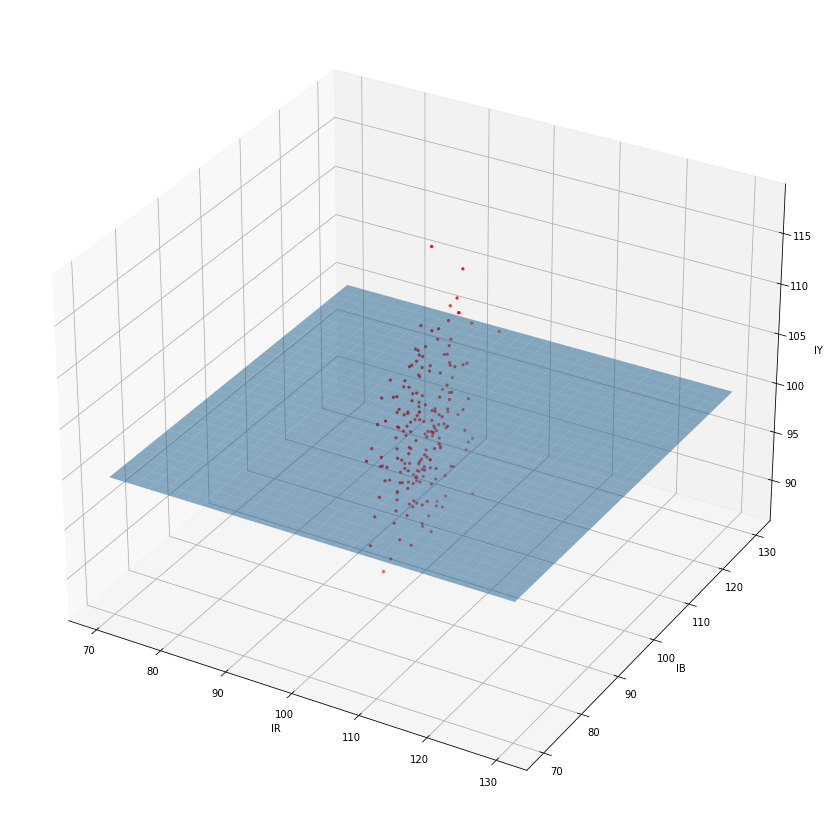

In [36]:
dfN4 = df_input.loc['N438446']

fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(dfN4['IR'], dfN4['IB'], dfN4['IY'], marker='.', color='red')
ax.set_xlabel("IR")
ax.set_ylabel("IB")
ax.set_zlabel("IY")

coefs = model[0].estimator.estimator_.coef_
intercept = model[0].estimator.estimator_.intercept_
xs = np.tile(np.arange(61)+70, (61,1))
ys = np.tile(np.arange(61)+70, (61,1)).T
zs = xs*coefs[0]+ys*coefs[1]+intercept

ax.plot_surface(xs,ys,zs, alpha=0.5)